# Introduce NOtebook the Use Case

In [ ]:
!pip install -q tensorflow pandas scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import random
import matplotlib.pyplot as plt

In [ ]:
def generate_synthetic_reviews(n=500):
    ratings = [1, 2, 3, 4, 5]
    products = ['Wireless Earbuds', 'Smartwatch', 'Bluetooth Speaker', 'E-reader', 'Fitness Tracker']
    preferences = ['Sound Quality', 'Battery Life', 'Design', 'Ease of Use', 'Durability']
    reviews = []
    for _ in range(n):
        rating = random.choice(ratings)
        product = random.choice(products)
        preference = random.choice(preferences)
        reviews.append([rating, product, preference])
    return pd.DataFrame(reviews, columns=['Rating', 'Product', 'Top_Preference'])

reviews_df = generate_synthetic_reviews()
reviews_df.head()

,Rating,Product,Top_Preference
0,3,Fitness Tracker,Battery Life
1,3,E-reader,Sound Quality
2,4,Bluetooth Speaker,Sound Quality
3,4,Wireless Earbuds,Durability
4,3,E-reader,Battery Life


In [ ]:
enc = OneHotEncoder(sparse_output=False)
encoded = enc.fit_transform(reviews_df[['Product', 'Top_Preference']])
scaler = MinMaxScaler()
scaled_ratings = scaler.fit_transform(reviews_df[['Rating']])
X = np.hstack([scaled_ratings, encoded])
input_dim = X.shape[1]

In [ ]:
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(input_dim, activation='tanh')
    ])
    return model

In [ ]:
def build_discriminator(input_dim):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(128, activation='relu'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
latent_dim = 16
generator = build_generator(latent_dim)
discriminator = build_discriminator(input_dim)

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input = layers.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

generator.summary()
discriminator.summary()
gan.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,563 (154.54 KB)

 Trainable params: 38,795 (151.54 KB)

 Non-trainable params: 768 (3.00 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,097 (141.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 36,097 (141.00 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 11)             │        39,563 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │        36,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,660 (295.55 KB)

 Trainable params: 38,795 (151.54 KB)

 Non-trainable params: 36,865 (144.00 KB)

In [ ]:
batch_size = 32
epochs = 1000

for epoch in range(epochs):
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_data = X[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_data = generator.predict(noise, verbose=0)

    X_combined = np.vstack([real_data, fake_data])
    y_combined = np.array([1] * batch_size + [0] * batch_size)

    discriminator.trainable = True
    d_loss, d_acc = discriminator.train_on_batch(X_combined, y_combined)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    y_gen = np.ones(batch_size)

    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gen)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss:.4f}, D Acc: {d_acc:.4f}, G Loss: {g_loss:.4f}")

Epoch 100/1000, D Loss: 0.5771, D Acc: 0.6909, G Loss: 1.0051
Epoch 200/1000, D Loss: 0.4970, D Acc: 0.7559, G Loss: 1.6789
Epoch 300/1000, D Loss: 0.3900, D Acc: 0.8211, G Loss: 2.7435
Epoch 400/1000, D Loss: 0.3392, D Acc: 0.8545, G Loss: 2.8169
Epoch 500/1000, D Loss: 0.2774, D Acc: 0.8836, G Loss: 3.1161
Epoch 600/1000, D Loss: 0.2338, D Acc: 0.9030, G Loss: 3.4679
Epoch 700/1000, D Loss: 0.2023, D Acc: 0.9168, G Loss: 3.8039
Epoch 800/1000, D Loss: 0.1787, D Acc: 0.9272, G Loss: 4.0942
Epoch 900/1000, D Loss: 0.1610, D Acc: 0.9351, G Loss: 4.3599
Epoch 1000/1000, D Loss: 0.1474, D Acc: 0.9413, G Loss: 4.5975


In [ ]:
noise = np.random.normal(0, 1, (10, latent_dim))
synthetic_data = generator.predict(noise, verbose=0)
print("\nGenerated Synthetic Data (first 9 samples):")
pd.DataFrame(synthetic_data[:9])


Generated Synthetic Data (first 9 samples):


,0,1,2,3,4,5,6,7,8,9,10
0,0.608841,-0.008501,0.462403,0.310042,0.271961,0.248304,0.979994,0.042566,-0.109308,-0.048549,-0.055654
1,0.529416,0.043912,-0.065919,0.065789,0.243917,0.893605,0.902832,-0.055442,0.011227,-0.015602,-0.030206
2,0.367327,0.040493,0.097992,0.029689,0.791877,0.021992,0.468388,0.232280,0.103164,-0.059983,0.075027
3,-0.036585,-0.017616,-0.063461,0.126143,0.073347,0.783029,0.852567,-0.058928,0.096551,-0.032083,0.013682
4,0.948997,0.147614,0.169472,0.332203,-0.179569,0.403174,0.999636,-0.036363,-0.026487,-0.053476,-0.166335
5,0.234151,-0.036934,0.160365,0.961579,0.031821,0.027572,0.115085,0.005839,0.951686,0.077696,0.091172
6,0.151935,0.125689,0.116203,0.797478,0.176058,-0.101141,-0.021093,-0.068293,0.986282,-0.006154,0.087533
7,0.530639,0.028192,0.500066,0.162853,0.164020,0.286079,0.777008,0.025532,0.189774,-0.012954,0.045697
8,-0.224314,0.064241,-0.167787,0.525114,0.136040,0.559575,-0.058274,0.034198,0.899631,-0.029020,0.051617


Epoch 100/1000, D Loss: 0.1366, D Acc: 0.9463, G Loss: 4.8120
Epoch 200/1000, D Loss: 0.1282, D Acc: 0.9501, G Loss: 5.0060
Epoch 300/1000, D Loss: 0.1215, D Acc: 0.9529, G Loss: 5.2306
Epoch 400/1000, D Loss: 0.1160, D Acc: 0.9552, G Loss: 5.4215
Epoch 500/1000, D Loss: 0.1101, D Acc: 0.9578, G Loss: 5.6292
Epoch 600/1000, D Loss: 0.1046, D Acc: 0.9602, G Loss: 5.8238
Epoch 700/1000, D Loss: 0.1014, D Acc: 0.9614, G Loss: 5.9673
Epoch 800/1000, D Loss: 0.0975, D Acc: 0.9631, G Loss: 6.1506
Epoch 900/1000, D Loss: 0.0942, D Acc: 0.9644, G Loss: 6.3063
Epoch 1000/1000, D Loss: 0.0920, D Acc: 0.9653, G Loss: 6.4595


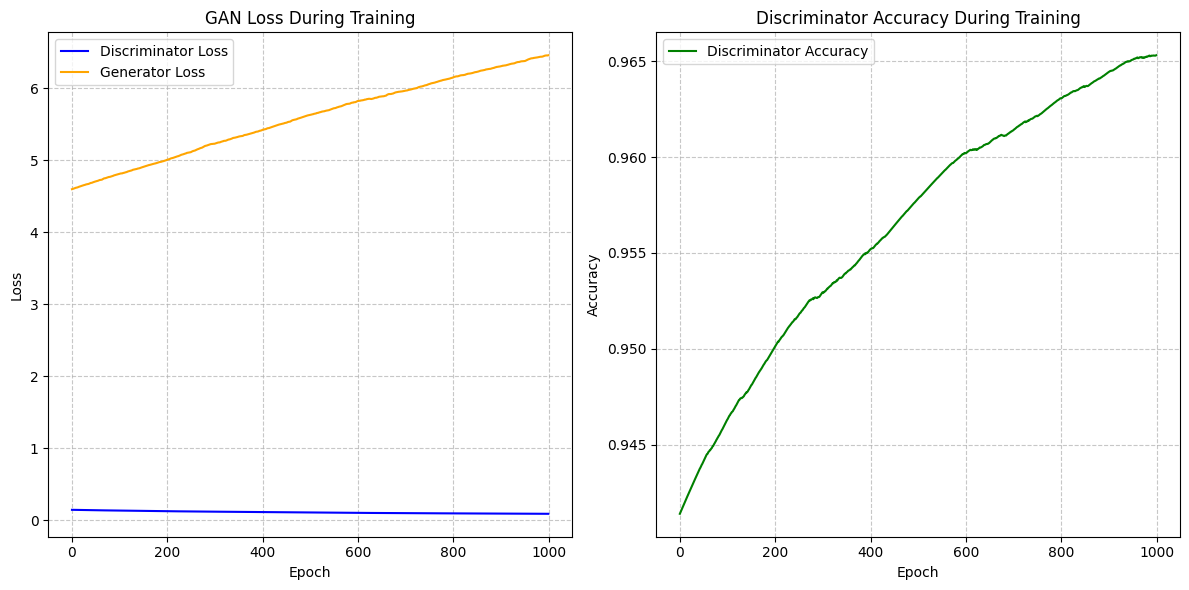

In [ ]:
# CODE FROM GEMINI

import numpy as np
import matplotlib.pyplot as plt
# Assuming 'X', 'generator', 'discriminator', 'gan', 'latent_dim' are already defined
# (e.g., Keras models for generator, discriminator, and the combined GAN)

batch_size = 32
epochs = 1000

# Lists to store loss and accuracy values
d_losses = []
g_losses = []
d_accuracies = []

for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_data = X[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_data = generator.predict(noise, verbose=0)

    # Combine real and fake data for discriminator training
    X_combined = np.vstack([real_data, fake_data])
    # Labels: 1 for real, 0 for fake
    y_combined = np.array([1] * batch_size + [0] * batch_size)

    # Train discriminator
    discriminator.trainable = True # Ensure discriminator is trainable
    d_loss, d_acc = discriminator.train_on_batch(X_combined, y_combined)

    # ---------------------
    #  Train Generator
    # ---------------------
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    # Generator wants discriminator to classify fakes as real (label 1)
    y_gen = np.ones(batch_size)

    # Freeze discriminator weights for generator training
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store losses and accuracy
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    d_accuracies.append(d_acc)


    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss:.4f}, D Acc: {d_acc:.4f}, G Loss: {g_loss:.4f}")

# -----------------------------------
#  Plotting the Loss and Accuracy Curves
# -----------------------------------

plt.figure(figsize=(12, 6))

# Plotting Losses
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(d_losses, label='Discriminator Loss', color='blue')
plt.plot(g_losses, label='Generator Loss', color='orange')
plt.title('GAN Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plotting Discriminator Accuracy (optional, but useful)
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(d_accuracies, label='Discriminator Accuracy', color='green')
plt.title('Discriminator Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjusts plot parameters for a tight layout
plt.show()

# Seeing the vector output as natural language

The output of the Discriminator are numeric vectors. But, what does that look like in "human readable form"? Below is code to see the vector output "unencoded".

In [ ]:
# Reverse encoding
decoded = []

for row in synthetic_data:
    rating_scaled = row[0]
    product_vector = row[1:1+5]
    pref_vector = row[6:6+5]  # Adjust these indexes based on your encoder

    rating = scaler.inverse_transform([[rating_scaled]])[0][0]
    product = enc.categories_[0][np.argmax(product_vector)]
    preference = enc.categories_[1][np.argmax(pref_vector)]

    decoded.append({
        "Rating": round(rating, 1),
        "Product": product,
        "Top_Preference": preference
    })

pd.DataFrame(decoded)


,Rating,Product,Top_Preference
0,3.4,E-reader,Battery Life
1,3.1,Wireless Earbuds,Battery Life
2,2.5,Smartwatch,Battery Life
3,0.9,Wireless Earbuds,Battery Life
4,4.8,Wireless Earbuds,Battery Life
5,1.9,Fitness Tracker,Durability
6,1.6,Fitness Tracker,Durability
7,3.1,E-reader,Battery Life
8,0.1,Wireless Earbuds,Durability
9,3.3,E-reader,Battery Life


# Understanding GAN Outputs in Structured Data

In this notebook, you'll learn how to interpret the output of a GAN trained on structured data (like customer reviews). Unlike image GANs, this generator produces numerical encodings representing categories like product, rating, and customer preference.

Why can't I see readable reviews? Because the generator outputs numeric representations, not actual words. These need to be decoded using the encoders and scalers we used during preprocessing.

In [ ]:

# Run this AFTER you have trained your GAN and generated `synthetic_data`
decoded = []

for row in synthetic_data:
    rating_scaled = row[0]
    product_vector = row[1:1+5]  # Adjust slice for your one-hot length
    pref_vector = row[6:6+5]     # Adjust based on how many features per field

    rating = scaler.inverse_transform([[rating_scaled]])[0][0]
    product = enc.categories_[0][np.argmax(product_vector)]
    preference = enc.categories_[1][np.argmax(pref_vector)]

    decoded.append({
        "Rating": round(rating, 1),
        "Product": product,
        "Top_Preference": preference
    })

pd.DataFrame(decoded)


,Rating,Product,Top_Preference
0,3.4,E-reader,Battery Life
1,3.1,Wireless Earbuds,Battery Life
2,2.5,Smartwatch,Battery Life
3,0.9,Wireless Earbuds,Battery Life
4,4.8,Wireless Earbuds,Battery Life
5,1.9,Fitness Tracker,Durability
6,1.6,Fitness Tracker,Durability
7,3.1,E-reader,Battery Life
8,0.1,Wireless Earbuds,Durability
9,3.3,E-reader,Battery Life



### ✅ Takeaways for Students
- GANs trained on **structured data** output encoded numeric arrays.
- We can decode these arrays using inverse transforms and category lookups.
- This is how **synthetic tabular data** is created for use cases like privacy-safe testing, recommender systems, and simulation.

Want to generate human-readable text? You'll need **text GANs**, **LSTMs**, or **transformers**, which we’ll explore later!
